In [1]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

from hydra import initialize
try:
    initialize(version_base=None, config_path="../sam2_logs/", job_name="predict_run")
except ValueError:
    pass

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI

from helpers.configurations import TRACK_TO_METAINFO
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from custom_model_builder import build_sam2former

/home/guests/tuna_gurbuz/prototype


In [2]:
model_size_dict = {
    'base': {
        'config': '03_28_11_32/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/03_28_11_32/checkpoints/checkpoint_1340.pt',
        },
}

# Model
model_size = 'base'
config = model_size_dict[model_size]['config']
ck = model_size_dict[model_size]['ck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
submodel, object_labels, _, _ = build_sam2former(config, ck, device=device)

OmegaConf resolved successfully


/home/guests/tuna_gurbuz/prototype/custom_models/models/sam2former/msdeformattn.py:310: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


In [3]:
# Dataset
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('over_train',
                           len_video=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!



100%|██████████| 3/3 [00:12<00:00,  4.19s/it]

Lenght of the dataset! 1


In [4]:
seed = 2 # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
if_break = False

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
with torch.no_grad():
    submodel.eval()
    for idx, sample in enumerate(test_loader):
        batched_video_data_val = sample[0].to(device)
        seg_mask = sample[1]  # List of PIL Image for debug
        masks_val = sample[0].masks.to(device)
        all_frame_outputs_val = submodel(batched_video_data_val)

/home/guests/tuna_gurbuz/miniforge3/envs/trainenv/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# Image
image = batched_video_data_val.img_batch[0,0].cpu()
unnormalized_image = toPILimage(revert_transform(image))
# GT Mask
gt_mask = masks_val[0,0].cpu()

In [6]:
# Predicted Mask
pred_logits = all_frame_outputs_val[0]['pred_logits'][0].cpu()
best_logits = torch.argmax(pred_logits, dim=1)
print(best_logits)
all_frame_outputs_val[0]['pred_masks'].shape
bin_pred_masks = (all_frame_outputs_val[0]['pred_masks'].sigmoid() > 0.5).float()
masks = bin_pred_masks[0].cpu()

tensor([0])


In [7]:
print("Predidcted masks shape", all_frame_outputs_val[0]['pred_masks'].shape)
print("Peedicted logits", pred_logits.softmax(dim=-1).max(dim=-1))
print("Masks shape", masks.shape)
mask_logit = all_frame_outputs_val[0]['pred_masks'][0].cpu()
masks = torch.cat([masks, mask_logit], dim=0)

Predidcted masks shape torch.Size([1, 1, 128, 128])
Peedicted logits torch.return_types.max(
values=tensor([0.5168]),
indices=tensor([0]))
Masks shape torch.Size([1, 128, 128])


IndexError: index 2 is out of bounds for dimension 0 with size 2

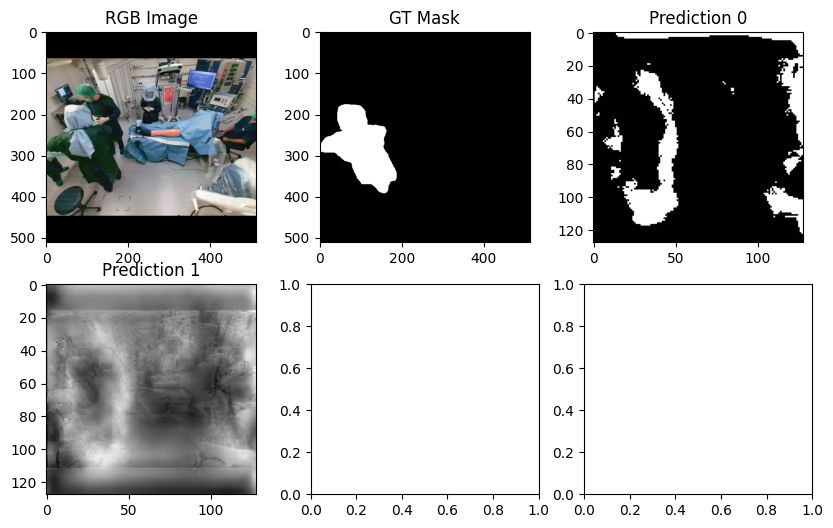

In [8]:
import matplotlib.pyplot as plt
import numpy as np

obj_out_idx = 0
black_placeholder = np.zeros_like(gt_mask)  # Black image placeholder

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# First row (RGB, GT, Black Placeholder)
axes[0, 0].imshow(unnormalized_image)
axes[0, 0].set_title("RGB Image")

axes[0, 1].imshow(gt_mask, cmap='gray')
axes[0, 1].set_title("GT Mask")

axes[0, 2].imshow(masks[0], cmap='gray')
axes[0, 2].set_title("Prediction 0")

# Second row (Predictions)
axes[1, 0].imshow(masks[1], cmap='gray')
axes[1, 0].set_title("Prediction 1")

axes[1, 1].imshow(masks[2], cmap='gray')
axes[1, 1].set_title("Prediction 2")

axes[1, 2].imshow(masks[3], cmap='gray')
axes[1, 2].set_title("Prediction 3")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()